# Language Modeling

A language model attempts to approximate the underlying statistics of a text corpus $P(tok_n | tok_1, tok_2, ..., tok_{n-1}; \theta)$ where $\theta$ is a set of learned parameters/weights. For the purposes of this notebook, tokens will be words. Language models can be used for a variety of applications, one of which being text generation. In this assignement we will be looking at language modeling techniques of increasing sophistication.

**Tips:**
- Read all the code. We don't ask you to write the training loops, evaluation loops, and generation loops, but it is often instructive to see how the models are trained and evaluated.
- If you have a model that is learning (loss is decreasing), but you want to increase accuracy, try using ``nn.Dropout`` layers just before the final linear layer to force the model to handle missing or unfamiliar data.

In [1]:
# start time - notebook execution
import time
start_nb = time.time()

# Set up

Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import unicodedata

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# Initialize the Autograder

In [3]:
# import the autograder tests
import hw3b_tests as ag

We will build a *vocabulary*, which will act as a dictionary of all the words our systems will know about. It will also allow us to map words to tokens, which will be unique indexes in the vocabulary. This will further allow us to transform words into one-hot vectors, where a word is represented as a vector of the same length as the vocabulary wherein all values are zeros except for the *i*th element, where *i* is the token number of the word.

In [4]:
class Vocab:
    def __init__(self, name):
        self.name = name                             # The name of the vocabulary
        self._word2index = {}                        # Map words to token index
        self._word2count = {}                        # Track how many times a word occurs in a corpus
        self._index2word = {0: "SOS", 1: "EOS"}      # Map token indexs back into words
        self._n_words = 2 # Count SOS and EOS        # Number of unique words in the corpus

    # Get a list of all words
    def get_words(self):
      return list(self._word2count.keys())

    # Get the number of words
    def num_words(self):
      return self._n_words

    # Convert a word into a token index
    def word2index(self, word):
      return self._word2index[word]

    # Convert a token into a word
    def index2word(self, word):
      return self._index2word[word]

    # Get the number of times a word occurs
    def word2count(self, word):
      return self._word2count[word]

    # Add all the words in a sentence to the vocabulary
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    # Add a single word to the vocabulary
    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

These are some helper functions to *normalize* texts, ie, make the text regular and remove some of the more problematic exceptions found in texts. This normalizer will make all words lowercase, trim plurals, and remove non-letter characters.

In [5]:
# Convert any unicode to ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Download a corpus. This corpus is the ascii text of the book, *The Silmarillion*, by J.R.R. Tolkein. It has a lot of non-common words and names to illustrate how language models deal with such things.

In [6]:
# if data.txt is not in the current directory, download it
if not os.path.isfile('data.txt'):
  !wget -O data.txt https://www.dropbox.com/s/pgvn1n7t4sjxt8r/silmarillion?dl=1

--2024-11-01 00:41:04--  https://www.dropbox.com/s/pgvn1n7t4sjxt8r/silmarillion?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/qp53tge07if28jhiwbtdb/silmarillion?rlkey=i09d3by7gw32i5yc9etv2e2ma&dl=1 [following]
--2024-11-01 00:41:05--  https://www.dropbox.com/scl/fi/qp53tge07if28jhiwbtdb/silmarillion?rlkey=i09d3by7gw32i5yc9etv2e2ma&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfbe800d400c8f46440f0fa2945.dl.dropboxusercontent.com/cd/0/inline/Cdh7obCS0Ofob466aI4xS-ldmy76nHxk0Vb5aa13eZIuexGtP9up-q-3REvbqJSS6vOK3GuZDGEWCU3Amikb_cf2YdhRZwytOqjHC3q2rCuJ1ed3vn9D1mDJ7tv0JJhd2pugl7RjcvQCMvgbT7cknoFZ/file?dl=1# [following]
--2024-11-01 00:41:05--  https://ucfbe800d400c8f46440f0fa2945.dl.dropboxusercont

Let's read in the data and take a look at it.

In [7]:
filename = 'data.txt'
with open(filename, encoding='utf-8') as f:
  text = f.read()
text[:1000]

'The Silmarillon Chapter 1\n\n\nOf the Beginning of Days It is told among the wise that the First War began before Arda was full-shaped, and ere yet there was any thing that grew or walked upon earth; and for long Melkor had the upper hand. But in the midst of the war a spirit of great strength and hardihood came to the aid of the Valar, hearing in the far heaven that there was battle in the Little Kingdom; and Arda was filled with the sound of his laughter. So came Tulkas the Strong, whose anger passes like a mighty wind, scattering cloud and darkness before it; and Melkor fled before his wrath and his laughter, and forsook Arda, and there was peace for a long age. And Tulkas remained and became one of the Valar of the Kingdom of Arda; but Melkor brooded in the outer darkness, and his hate was given to Tulkas for ever after.\n\nIn that time the Valar brought order to the seas and the lands and the mountains, and Yavanna planted at last the seeds that she had long devised. And since, w

Normalize the text and build the vocabulary

In [8]:
normalized_text = normalize_string(text)
VOCAB = Vocab("text")
VOCAB.add_sentence(normalized_text)

Make training and testing data splits.

In [9]:
# Convert every word into a token and build a numpy array of tokens
encoded_text = np.array([VOCAB.word2index(word) for word in normalized_text.split()])
print("The first 100 tokens")
print(encoded_text[:100])
# get the validation and the training data
test_split = 0.1
test_idx = int(len(encoded_text) * (1 - test_split))
TRAIN = encoded_text[:test_idx]
TEST = encoded_text[test_idx:]
# Decrease the size of the training set to make the assignment more tractable
TRAIN = TRAIN[:len(TRAIN)//10]

The first 100 tokens
[ 2  3  4  5  2  6  5  7  8  9 10 11  2 12 13  2 14 15 16 17 18 19 20 21
 22 23 24 25 19 26 27 13 28 29 30 31 32 22 33 34 35 36  2 37 38 39 40 41
  2 42  5  2 15 43 44  5 45 46 22 47 48 49  2 50  5  2 51 52 41  2 53 54
 13 25 19 55 41  2 56 57 22 18 19 58 59  2 60  5 61 62 39 63 48 64  2 65
 66 67 68 69]


# LSTM (20 Points)

A more sophisticated version of an RNN is a Long Short-Term Memory network (or an LSTM). It learns to decided what should be kept in the hidden state and what should be removed from the hidden state. This allows it to make better hidden states and thus learn a more accurate probability distribution and be a better generator.

We will make two LSTMs. First, we will make a neural network that uses Pytorch's built in `nn.LSTMCell`. The second time, we will write an LSTM memory cell from scratch.

**Complete the following network with two or more LSTMCell layers.** The network will take two inputs in its forward function:
- `x`: a sequence of words, represented as one-hots. The input should be a tensor of shape `1 x vocab_size` That is, each row is a one-hot (batch size is 1).
- `hc` which is a tuple containing (hidden_state, cell_state).

The output of the forward function will be:
- A sequence of output log probabilities. This output should be a tensor of shape `1 x vocab_size` where each row is a log probability distribution.
- A tuple containing (hidden_state, cell_state).

The network should contain two our more LSTMCell modules. Send the one-hot into the first LSTMCell along with the original `hc`. Then send the resulting hidden state to the next higher LSTMCell *along with the initial `hc`*. Keep doing this until you get to the top of the stack of LSTMCells. Once you get to the top of the stack, use an affine transformation to expand to vocabular size and generate a log probability with a log softmax.

Forward should return the output log probabilities and a (hidden state, cell state) tuple.

In [10]:
# build the model using the pytorch nn module
class MyLSTM(nn.ModuleList):
  def __init__(self, input_size, hidden_size, cell_type = nn.LSTMCell):
    super(MyLSTM, self).__init__()

    # init the parameters
    self.hidden_dim = hidden_size
    self.input_size = input_size

    ### Use the cell_type passed into the constructor as the type of LSTM cell module
    ### that is made. For the first part of the assignment, this will be the
    ### default nn.LSTMCell. For the second part, this will be the custom-written
    ### LSTM cell type.

    ### BEGIN SOLUTION
    self.lstm_cell1 = cell_type(input_size, hidden_size)
    self.lstm_cell2 = cell_type(hidden_size, hidden_size)
    self.output_layer = nn.Linear(hidden_size, input_size)
    ### END SOLUTION

  def forward(self, x, hc):
    # Return values
    output = None
    hidden = None
    cell = None

    # Pass the hidden and the cell state from one lstm cell to the next one
    # we also feed the output of the first layer lstm cell at time step t to the second layer cell
    # init both layer cells with the zero hidden and zero cell states

    ### BEGIN SOLUTION
    inter_hidden, inter_cell = self.lstm_cell1(x, hc)
    hidden, cell = self.lstm_cell2(inter_hidden, (inter_hidden, inter_cell))
    output = F.log_softmax(self.output_layer(hidden), dim = 1)
    ### END SOLUTION

    return output, (hidden.detach(), cell.detach())

  def init_hidden(self):
    # initialize the hidden state and the cell state to zeros
    return (torch.zeros(1, self.hidden_dim), # 1 is the batch size
            torch.zeros(1, self.hidden_dim)) # 1 is the batch size


Let's build our LSTM

In [11]:
# It's ok to change this cell, however, you should not need to change it much (if at all) - note: certain changes may break the autograder, e.g.,
# increasing the size of the hidden layer could cause out of memory errors in the autograder and large numbers of epochs could cause autograder to time
# out (pay attention to the runtime of your notebook and the warnings that are printed out at the end of the notebook)
LSTM_HIDDEN_SIZE = 8
LSTM_NUM_EPOCHS = 2
LSTM_LEARNING_RATE = 0.01

In [12]:
lstm = MyLSTM(VOCAB.num_words(), LSTM_HIDDEN_SIZE)
optimizer_lstm = optim.SGD(lstm.parameters(), lr=LSTM_LEARNING_RATE)
criterion_lstm = nn.NLLLoss()

In [13]:
# student check - the following test must return a value of 3 to receive credit (5 pts)
ag.LSTM_check()

Number of layers found, 5, is correct.
Test A: 5/5


In [14]:
# student check - the following test must return a value of 5 to receive credit (5 pts)
ag.unit_test_LSTM_structure()

torch.Size([1, 100]) torch.Size([1, 50]) torch.Size([1, 50])
NllLossBackward0
LogSoftmaxBackward0
AddmmBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
MulBack

## LSTM---Training

Here is the training loop. Notice it uses `get_rnn_x_y()` from HW2.


In [15]:
def train_lstm(net, optimizer, criterion, num_epochs, data):
  epoch_losses = []
  scheduler = ExponentialLR(optimizer, gamma=0.9)
  net.train()
  for epoch in range(num_epochs):
    losses = []
    hc = net.init_hidden()
    for i in range(len(data)-1):
      x, y = ag.get_rnn_x_y(data, i, VOCAB.num_words())
      x = x.float()
      output, hc = net(x, hc)
      loss = criterion(output, y)
      losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i%1000 == 0:
        print('iter', i, 'loss', torch.stack(losses).mean().item())
    scheduler.step()
    print('epoch', epoch, 'loss', torch.stack(losses).mean().item())
    epoch_losses.append(torch.stack(losses).mean().item())
  return epoch_losses

In [16]:
epoch_losses = train_lstm(lstm, optimizer_lstm, criterion_lstm, num_epochs=LSTM_NUM_EPOCHS, data=TRAIN)

iter 0 loss 9.000749588012695
iter 1000 loss 8.570307731628418
iter 2000 loss 8.448580741882324
iter 3000 loss 8.260414123535156
iter 4000 loss 8.1170015335083
iter 5000 loss 8.027204513549805
iter 6000 loss 7.952082633972168
iter 7000 loss 7.837630271911621
iter 8000 loss 7.739604949951172
iter 9000 loss 7.632733345031738
iter 10000 loss 7.556149959564209
iter 11000 loss 7.486486911773682
epoch 0 loss 7.447731971740723
iter 0 loss 9.179214477539062
iter 1000 loss 6.5498199462890625
iter 2000 loss 6.5823259353637695
iter 3000 loss 6.510133266448975
iter 4000 loss 6.549914360046387
iter 5000 loss 6.5874857902526855
iter 6000 loss 6.621036052703857
iter 7000 loss 6.604976177215576
iter 8000 loss 6.584723949432373
iter 9000 loss 6.543672561645508
iter 10000 loss 6.526050090789795
iter 11000 loss 6.50928258895874
epoch 1 loss 6.494110584259033


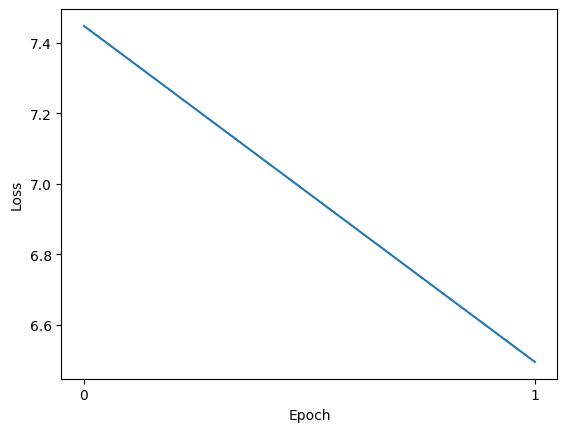

In [18]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(epoch_losses)))
plt.plot(epoch_losses)

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

## LSTM---Testing

Evaluation works the same as with the RNN.

In [19]:
# student check - the following test must return a value less than 1000 to receive credit (10 pts)
ag.eval_lstm_1(max_perplexity=1000)

557.9765625
Perplexity is less than 1000
Test C: 10/10


## LSTM---Generation

Generation works the same as the RNN. In fact you will notice that we can use the `prep_hidden_state` and `generate_rnn` functions without modification.

In [20]:
# It's ok to change this cell
LSTM_TEMPERATURE = 0.5

In [21]:
# COPY YOUR HW3-A SOLUTION HERE
def token2onehot(token, vocab_size = VOCAB.num_words()):
  one_hot = None
  ### BEGIN SOLUTION
  one_hot = F.one_hot(torch.tensor([token]), num_classes = vocab_size)
  ### END SOLUTION
  return one_hot

# COPIED FROM HW3-A
def prep_hidden_state(tokenized_input, rnn, verbose=False):
  # Get an initial hidden state
  hidden_state = rnn.init_hidden()
  # Run the input prompt through the RNN to build up the hidden state.
  # Discard the outputs (we are not trying to make predictions) until we get to the end
  for token in tokenized_input:
    if verbose:
      print("current token:", token, VOCAB.index2word(token))
    # Get the one-hot for the current token
    x = token2onehot(token)
    x = x.float()
    # Run the current one-hot and hidden state through the RNN
    output, hidden_state = rnn(x, hidden_state)
    # Get the highest predicted token
    next_token = output.argmax().item()
    if verbose:
      print("predicted next token:", next_token, VOCAB.index2word(next_token), '\n')
  return hidden_state

# COPY YOUR HW3-A SOLUTION HERE
def my_temperature_sample(log_probs, temperature=1.0):
  token = None
  ### BEGIN SOLUTION
  divided_logprobs = log_probs / temperature
  probs = torch.exp(divided_logprobs)
  token = torch.multinomial(probs, num_samples=1).item()
  ### END SOLUTION
  return token

# COPIED FROM HW3-A
def generate_rnn(rnn, num_new_tokens, token, hidden_state, fn=lambda d:d.argmax().item(), verbose=False):
  # Keep generating more by feeding the predicted output back into the RNN as input
  # Start with the last token of the input prompt and the newly prepped hidden state
  if verbose:
    print("Generating continuation:\n")
  continuation = []
  for n in range(num_new_tokens):
    if verbose:
      print("current token:", token, VOCAB.index2word(token))
    # Get the one-hot for the current token
    x = token2onehot(token)
    x = x.float()
    # Run the current one-hot through the RNN
    output, hidden_state = rnn(x, hidden_state)
    # Predict the next token
    next_token = fn(output)
    if verbose:
      print("predicted next token:", next_token, VOCAB.index2word(next_token), '\n')
    # Remember the new token
    continuation.append(next_token)
    # update the current
    token = next_token
  return continuation

# Example input prompt:
input_prompt = "the First War began"
# How long should the continuation be?
num_new_tokens = 10

# Normalize the input
normalized_input = normalize_string(input_prompt)
# Tokenize the input
tokenized_input = [VOCAB.word2index(w) for w in normalized_input.split()]
print("input prompt:", input_prompt)
print("input tokens:", tokenized_input, '\n')

# Get the hidden state that represents the input prompt
print("Prepping hidden state:\n")
hidden_state = prep_hidden_state(tokenized_input, lstm, verbose=True)

# Generate the continuation. Use the argmax function to sample from the RNN's outputs
token = tokenized_input[-1]
continuation = generate_rnn(lstm, num_new_tokens, token, hidden_state, fn=lambda d:my_temperature_sample(d, LSTM_TEMPERATURE), verbose=True)

# All done
print("Final continuation:")
print(continuation)
continuation_text = [VOCAB.index2word(t) for t in continuation]
print(continuation_text)
print("Final:")
print(input_prompt + ' ' + ' '.join(continuation_text))

input prompt: the First War began
input tokens: [2, 14, 15, 16] 

Prepping hidden state:

current token: 2 the
predicted next token: 2 the 

current token: 14 first
predicted next token: 2 the 

current token: 15 war
predicted next token: 2 the 

current token: 16 began
predicted next token: 2 the 

Generating continuation:

current token: 16 began
predicted next token: 5 of 

current token: 5 of
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 5 of 

current token: 5 of
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 5 of 

current token: 5 of
predicted next token: 2 the 

Final continuation:
[5, 2, 2, 5, 2, 2, 2, 2, 5, 2]
['of', 'the', 'the', 'of', 'the', 'the', 'the', 'the', 'of', 'the']
Final:
the First War began of the the of the th

# LSTM From Scratch (40 Points)

Now we do LSTM the hard way---creating the LSTM cells by hand.

**Complete the following functions inside the `MyLSTMCell` class.**

We have broken the forward function into multiple parts:
- Forget gate: determine what of the previous cell state should be discarded (by multiplying 0 or 1 produced by a sigmoid against the cell state).  `forget_gate()` implements $f=\sigma(W_{i,f}x+b_{i,f} + W_{h,f}h+b_{h,f})$.
- Input gate: determine what of the input should be introduced to the cell memory. `input_gate()` implements $i=\sigma(W_{i,i}x+b_{i,i}+W_{h,i}h+b_{h,i})$
- Cell memory: update the previous cell memory state to make a new cell memory state. `cell_memory()` implements $c'=f*c + i*tanh(W_{i,g}x+b_{i,g} + W_{h,g}h + b_{h,g})$.
- Output gate: determine what from the current cell memory state. `output_gate()` implements $o=\sigma(W_{i,o}x+b_{i,o}+W_{h,o}h+b_{h,o})$.
- A final function `hidden_out()` will produce the new hidden state by implementing $h'=o*tanh(c')$.

You will also need to initialize any linear layer modules, activation functions, etc. in the constructor.

In [22]:
class MyLSTMCell(torch.nn.Module):

  def __init__(self, input_size=10, hidden_size=64):
    super(MyLSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    ### BEGIN SOLUTION
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

    self.Wif = nn.Linear(input_size, hidden_size)
    self.Whf = nn.Linear(hidden_size, hidden_size)

    self.Wii = nn.Linear(input_size, hidden_size)
    self.Whi = nn.Linear(hidden_size, hidden_size)

    self.Wig = nn.Linear(input_size, hidden_size)
    self.Whg = nn.Linear(hidden_size, hidden_size)

    self.Wio = nn.Linear(input_size, hidden_size)
    self.Who = nn.Linear(hidden_size, hidden_size)
    ### END SOLUTION

  ### The Forget Gate takes in the input (x) and hidden state (h)
  ### The input and hidden state pass through their own linear compression layers,
  ### then are concatenated and passed through a sigmoid
  def forget_gate(self, x, h):
    f = None # The gate vector to return
    ### BEGIN SOLUTION
    f = self.sigmoid(self.Wif(x) + self.Whf(h))
    ### END SOLUTION
    return f

  ### The Input Gate takes the input (x) and hidden state (h)
  ### The input and hidden state pass through their own linear compression layers,
  ### then are concatenated and passed through a sigmoid
  def input_gate(self, x, h):
    i = None # The gate vector to return
    ### BEGIN SOLUTION
    i = self.sigmoid(self.Wii(x) + self.Whi(h))
    ### END SOLUTION
    return i

  ### The Cell memory gate takes the results from the input gate (i), the results from the forget gate (f)
  ### the original input (x), the hidden state(h) and the previous cell state (c_prev).
  ### 1. The Cell memory gate compresses the input and hidden and concatenates them and passes it through a Tanh.
  ### 2. The resultant intermediate tensor is multiplied by the results from the input gate to determine
  ###    what new information is allowed to carry on
  ### 3. The results from the forget state are multiplied against the previous cell state (c_prev) to determine
  ###    what should be removed from the cell state.
  ### 4. The new cell state (c_next) is the new information that survived the input gate and the previous
  ###    cell state that survived the forget gate.
  ### The new cell state c_next is returned
  def cell_memory(self, i, f, x, h, c_prev):
    c_next = None
    ### BEGIN SOLUTION
    c_next = f * c_prev + i * self.tanh(self.Wig(x) + self.Whg(h))
    ### END SOLUTION
    return c_next

  ### The Out gate takes the original input (x) and the hidden state (h)
  ### The gate passes the input and hidden through their own compression layers and
  ### then concatenates to send through a sigmoid
  def out_gate(self, x, h):
    o = None # The gate vector to return
    ### BEGIN SOLUTION
    o = self.sigmoid(self.Wio(x) + self.Who(h))
    ### END SOLUTION
    return o

  ### This function assembles the new hidden state, give the results of the output gate (o)
  ### and the new cells sate (c_next).
  ### This function runs c_next through a tanh to get a 1 or -1 which will flip some of the
  ### elements of the output.
  def hidden_out(self, o, c_next):
    h_next = None
    ### BEGIN SOLUTION
    h_next = o * self.tanh(c_next)
    ### END SOLUTION
    return h_next

  def forward(self, x, hc):
    (h, c_prev) = hc
    # Equation 1. input gate
    i = self.input_gate(x, h)

    # Equation 2. forget gate
    f = self.forget_gate(x, h)

    # Equation 3. updating the cell memory
    c_next = self.cell_memory(i, f, x, h, c_prev)

    # Equation 4. calculate the main output gate
    o = self.out_gate(x, h)

    # Equation 5. produce next hidden output
    h_next = self.hidden_out(o, c_next)

    return h_next, c_next

  def init_hidden(self):
    return (torch.zeros(1, self.hidden_size),
            torch.zeros(1, self.hidden_size))

In [23]:
# student check - the following test must return a value of 6 to receive credit (5 pts)
ag.test_myLSTMCell_structure(MyLSTMCell)

torch.Size([1, 50]) torch.Size([1, 50])
NllLossBackward0
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
NllLossBackward0
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0

In [24]:
# student check - the following test must return a value of 8 to receive credit (5 pts)
ag.MyLSTMCell_linear_layer_size_check()

Number of linear layers found, 8, is correct.
Test E: 5/5.0


Let's build a cell. A cell doesn't do much by itself.

In [25]:
cell = MyLSTMCell(input_size=VOCAB.num_words(), hidden_size=64)

In [26]:
# student check - the following test must return a value of 22 to receive credit (10 pts)
ag.test_gate_structure(cell)

SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
Sigmoi

Now let's load your `MyLSTMCell` class into `MyLSTM`.

In [27]:
# It's ok to change this cell, however, you should not need to change it much (if at all) - note: certain changes may break the autograder, e.g.,
# increasing the size of the hidden layer could cause out of memory errors in the autograder and large numbers of epochs could cause autograder to time
# out (pay attention to the runtime of your notebook and the warnings that are printed out at the end of the notebook)
MY_CELL_HIDDEN_SIZE = 4
MY_CELL_NUM_EPOCHS = 2
MY_CELL_LEARNING_RATE = 0.05

In [30]:
my_cell_lstm = MyLSTM(input_size=VOCAB.num_words(), hidden_size=MY_CELL_HIDDEN_SIZE, cell_type=MyLSTMCell)
optimizer_my_cell = optim.SGD(my_cell_lstm.parameters(), lr=MY_CELL_LEARNING_RATE)
criterion_my_cell = nn.NLLLoss()

## LSTM From Scratch---Training

Lets see if your combination of `MyLSTM` using `MyLSTMCell` learns. We don't need to update the training loop

In [31]:
epoch_losses = train_lstm(my_cell_lstm, optimizer_my_cell, criterion_my_cell, num_epochs=MY_CELL_NUM_EPOCHS, data=TRAIN)

iter 0 loss 8.84737491607666
iter 1000 loss 7.934452533721924
iter 2000 loss 7.461420059204102
iter 3000 loss 7.136561393737793
iter 4000 loss 7.024417877197266
iter 5000 loss 6.948768615722656
iter 6000 loss 6.870439052581787
iter 7000 loss 6.797117710113525
iter 8000 loss 6.734395503997803
iter 9000 loss 6.659026622772217
iter 10000 loss 6.610270023345947
iter 11000 loss 6.563591003417969
epoch 0 loss 6.5378923416137695
iter 0 loss 8.521647453308105
iter 1000 loss 6.005076885223389
iter 2000 loss 6.020057678222656
iter 3000 loss 5.970968723297119
iter 4000 loss 5.99897575378418
iter 5000 loss 6.02289342880249
iter 6000 loss 6.033974647521973
iter 7000 loss 6.035773277282715
iter 8000 loss 6.032357215881348
iter 9000 loss 6.009108543395996
iter 10000 loss 6.00098180770874
iter 11000 loss 5.987096309661865
epoch 1 loss 5.978094577789307


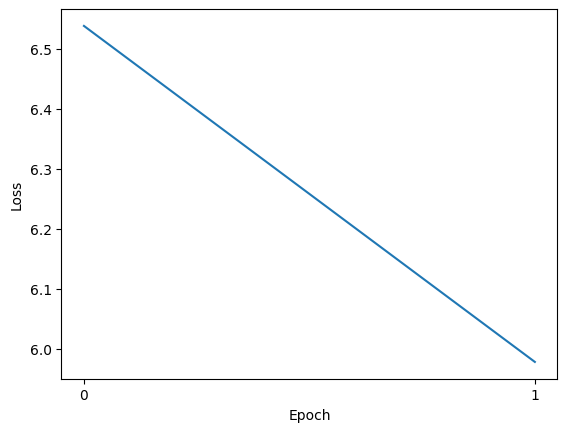

In [32]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(epoch_losses)))
plt.plot(epoch_losses)

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

## LSTM From Scratch---Testing

We don't need to update the evaluation loop

In [33]:
# student check - the following test must return a value less than 1000 to receive credit (20 pts)
ag.eval_lstm_2(max_perplexity=1000)

466.27557373046875
Perplexity is less than 1000
Test G: 20/20


## LSTM From Scratch---Generation

Generation works the same.

In [34]:
# It's ok to change this cell
MY_CELL_TEMPERATURE = 0.5

In [35]:
# Example input prompt:
input_prompt = "the First War began"
# How long should the continuation be?
num_new_tokens = 10

# Normalize the input
normalized_input = normalize_string(input_prompt)
# Tokenize the input
tokenized_input = [VOCAB.word2index(w) for w in normalized_input.split()]
print("input prompt:", input_prompt)
print("input tokens:", tokenized_input, '\n')

# Get the hidden state that represents the input prompt
print("Prepping hidden state:\n")
hidden_state = prep_hidden_state(tokenized_input, my_cell_lstm, verbose=True)

# Generate the continuation. Use the argmax function to sample from the RNN's outputs
token = tokenized_input[-1]
continuation = generate_rnn(my_cell_lstm, num_new_tokens, token, hidden_state, fn=lambda d:my_temperature_sample(d, MY_CELL_TEMPERATURE), verbose=True)

# All done
print("Final continuation:")
print(continuation)
continuation_text = [VOCAB.index2word(t) for t in continuation]
print(continuation_text)
print("Final:")
print(input_prompt + ' ' + ' '.join(continuation_text))

input prompt: the First War began
input tokens: [2, 14, 15, 16] 

Prepping hidden state:

current token: 2 the
predicted next token: 2 the 

current token: 14 first
predicted next token: 2 the 

current token: 15 war
predicted next token: 2 the 

current token: 16 began
predicted next token: 2 the 

Generating continuation:

current token: 16 began
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 5 of 

current token: 5 of
predicted next token: 39 . 

current token: 39 .
predicted next token: 22 and 

current token: 22 and
predicted next token: 2 the 

current token: 2 the
predicted next token: 22 and 

current token: 22 and
predicted next token: 2 the 

current token: 2 the
predicted next token: 277 him 

current token: 277 him
predicted next token: 2 the 

Final continuation:
[2, 2, 5, 39, 22, 2, 22, 2, 277, 2]
['the', 'the', 'of', '.', 'and', 'the', 'and', 'the', 'him', 'the']
Final:
the First War began the t

# Attention (40 Points)

Attention allows the network to look back at previous data when trying to predict the next token.

We will split the LSTM into an Encoder and a Decoder. The Encoder's job will be to update the hidden state based on the latest token. The Decoder's job is to predict the next token (log softmax over the vocabulary) based on the current hidden state as well as *n* previous hidden states. You will see that the training loop now collects up a stack of hidden states to pass to the Decoder. The Decoder will figure out how much the network should attend to each of the *n* prior hidden states before making its final prediction.

The Encoder will be a simple `nn.LSTMCell`. While the encoder could be more complicated, this allows us to focus on the Decoder. The Decoder is more complicated, involving both an LSTMCell and an attention mechanism.

**Complete the class defnition below**

`MyAttentionDecoder` will implement another `nn.LSTMCell` plus an attention mechanism.

Inputs:
- `x`: a one-hot of the current token as a `1 x vocab_size` tensor
- `hc`: a tuple containing a tuple with encoder's hidden state and memory cell state. The hidden state and cell state are both `1 x hidden_size` tensors.
- `encoder_outputs`: a history of *n* encoded hidden states, as a `n x hidden_size` tensor (this data is not batched).

Outputs:
- `h_hat`: a log softmax probability distribution over the vocabular, as a `1 x vocab_size` tensor
- `hc_out`: a tuple containing the LSTMCell's hidden state and memory cell state. The hidden state and cell state are both `1 x hidden_size` tensors.

In [36]:
class MyAttentionDecoder(nn.Module):
  def __init__(self, hidden_size, input_size, max_length):
    super(MyAttentionDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.max_length = max_length
    ### BEGIN SOLUTION
    #init lstm-cell
    #init input-layer linear with in_features=input_size, out_features=hidden_size
    #init input-hidden linear with in-features= 2*hidden_size, out-featues= max_length
    #init hidden-hidden linear...
    #init output linear...
    self.lstm_cell = nn.LSTMCell(hidden_size, hidden_size)
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.input_hidden = nn.Linear(2*hidden_size, max_length)
    self.hidden_hidden = nn.Linear(2*hidden_size, hidden_size)
    self.output_layer = nn.Linear(hidden_size, input_size)
    ### END SOLUTION

  def forward(self, x, hc, encoder_outputs):
    log_probs = None
    hc_out = None
    ### BEGIN SOLUTION
    # step 1 input x into linear layer, i.e.x = linear(x)  #size(batch_size, hidden_size)
    # step 2 concat x with hidden state hc[0], using torch.cat, output vector xh
    # step 3 input xh into the next linear layer
    # step 4 input output of the above to the softmax layer, output is attention scores # size(batch_size, max_length)
    # Example: att_score = [[0.1, 0.2, 0.3, 0.2, 0.2]]  # size(batch_size, max_length)
    #           encoder_output = [[0.8, ...], [0.6,...], [...], [...], [...]] #size(batch_size, hidden_size)
    # To use torch.bmm resize both att_score and encoder_output to match each other
    # For encoder_output, we want sth like (batch_size, max_length, hidden_size)
    # (To resize in pytorch is to use torch.unsqueeze(dim))
    # for attn_scores, we want sth like (batch_size, 1, max_length)
    # So that when you do bmm, the result will be (batch_size, 1, hidden_size)
    #concat the output of bmm with x
    #step 6: input into another linear layer(purple)
    #step 7: relu -> new_hidden
    #step 8: input nuw_hidden into your output_linear and log_softmax -> log_probs
    #step 9: input new_hidden into your lstm-cell -> hc_out
    h, c = hc
    x = self.input_layer(x)
    xh = torch.cat((x, h), dim = 1)
    attn_scores = self.input_hidden(xh)
    attn_weights = F.softmax(attn_scores, dim = 1)
    attn_weights = attn_weights.unsqueeze(1)
    encoder_outputs = encoder_outputs.unsqueeze(0)
    context = torch.bmm(attn_weights, encoder_outputs).squeeze(1)

    x_combined = torch.cat((x, context), dim = 1)
    x_combined = self.hidden_hidden(x_combined)
    new_hidden = F.relu(x_combined)
    h, c = self.lstm_cell(new_hidden, (h, c))
    output = self.output_layer(h)
    log_probs = F.log_softmax(output, dim=1)
    hc_out = (h, c)
    ### END SOLUTION
    return log_probs, hc_out

  def init_hidden(self):
    return (torch.zeros(1, self.hidden_size),
            torch.zeros(1, self.hidden_size))

In [37]:
# It's ok to change this cell, however, you should not need to change it much (if at all) - note: certain changes may break the autograder, e.g.,
# increasing the size of the hidden layer could cause out of memory errors in the autograder and large numbers of epochs could cause autograder to time
# out (pay attention to the runtime of your notebook and the warnings that are printed out at the end of the notebook)
ATTN_MAX_LENGTH = 2  # The number of past hidden states that can be attended to
ATTN_HIDDEN_SIZE = 8
ATTN_NUM_EPOCHS = 2
ATTN_LEARNING_RATE = 0.01

In [38]:
attn_encoder = nn.LSTMCell(VOCAB.num_words(), ATTN_HIDDEN_SIZE)
attn_decoder = MyAttentionDecoder(ATTN_HIDDEN_SIZE, VOCAB.num_words(), ATTN_MAX_LENGTH)
attn_criterion = nn.NLLLoss()
attn_encoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=ATTN_LEARNING_RATE, momentum=0.9)
attn_decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=ATTN_LEARNING_RATE, momentum=0.9)

In [39]:
# student check - the following test must return a value of 4 to receive credit (10 pts)
ag.test_attention_structure()

torch.Size([1, 100]) torch.Size([1, 64]) torch.Size([1, 64])
--
NllLossBackward0
LogSoftmaxBackward0
AddmmBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
ReluBackward0
AddmmBackward0
AccumulateGrad
CatBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SqueezeBackward1
BmmBackward0
UnsqueezeBackward0
SoftmaxBackward0
AddmmBackward0
AccumulateGrad
CatBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
ReluBackward0
AddmmBackward0
AccumulateGrad
CatBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SqueezeBackward1
BmmBackward0
UnsqueezeBackward0
SoftmaxBackward0
AddmmBa

In [40]:
# student check - the following test must return a value of 8 to receive credit (10 pts)
ag.attention_linear_layer_size_check()

Number of linear layers found, 4, is correct.
Test I: 10/10


## Attention---Training

The training loop is a bit more involved because it must collect up a number of past hidden states. It still uses your `get_rnn_x_y()` function though.

In [41]:
def train_attn(data, num_epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=ATTN_MAX_LENGTH):
  epoch_losses = []
  encoder.train()
  decoder.train()
  for epoch in range(num_epochs):
    losses = []
    # Get an empty hc
    encoder_hc = decoder.init_hidden()
    # Create an empty history of hiddens
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    for iter in range(len(data)-1):
      x, y = ag.get_rnn_x_y(data, iter, VOCAB.num_words())
      x = x.float()
      # Call encoder
      encoder_hidden, encoder_cell = encoder(x, encoder_hc)
      encoder_hc = (encoder_hidden, encoder_cell)
      # unbatch the hidden so it can be added to encoder_outputs
      encoder_output = encoder_hidden[0]
      # Shift all the previous outputs
      # Grab elements 1...max (dropping row 0) and flatten
      encoder_outputs = encoder_outputs[1:,:].view(-1)
      # Add the new output
      encoder_outputs = torch.cat((encoder_outputs, encoder_output.detach()))
      # re-fold
      encoder_outputs = encoder_outputs.view(max_length, -1)
      # decoder's input hc is the encoder's output hc
      decoder_hc = encoder_hc
      # Call the decoder
      decoder_output, decoder_hc = decoder(x, decoder_hc, encoder_outputs)

      loss = criterion(decoder_output, y)
      losses.append(loss)

      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()
      loss.backward()
      encoder_optimizer.step()
      decoder_optimizer.step()

      # Prep the decoder hc for the next iteration
      encoder_hc = (decoder_hc[0].detach(), decoder_hc[1].detach())

      if iter%1000 == 0:
        print("iter", iter, "loss", torch.stack(losses).mean().item())
    print("epoch", epoch, "loss", torch.stack(losses).mean().item())
    epoch_losses.append(torch.stack(losses).mean().item())
  return epoch_losses

In [42]:
epoch_losses = train_attn(TRAIN, ATTN_NUM_EPOCHS, attn_encoder, attn_decoder, attn_encoder_optimizer, attn_decoder_optimizer, attn_criterion, ATTN_MAX_LENGTH)

iter 0 loss 8.49933910369873
iter 1000 loss 6.993351459503174
iter 2000 loss 6.657444477081299
iter 3000 loss 6.451412677764893
iter 4000 loss 6.403214931488037
iter 5000 loss 6.357908725738525
iter 6000 loss 6.310579299926758
iter 7000 loss 6.266855239868164
iter 8000 loss 6.221811771392822
iter 9000 loss 6.160412788391113
iter 10000 loss 6.127425193786621
iter 11000 loss 6.085107803344727
epoch 0 loss 6.061407566070557
iter 0 loss 6.630087852478027
iter 1000 loss 5.598361968994141
iter 2000 loss 5.630965709686279
iter 3000 loss 5.5677170753479
iter 4000 loss 5.601202964782715
iter 5000 loss 5.623533725738525
iter 6000 loss 5.632328987121582
iter 7000 loss 5.634353160858154
iter 8000 loss 5.625655651092529
iter 9000 loss 5.5902814865112305
iter 10000 loss 5.5789265632629395
iter 11000 loss 5.554824352264404
epoch 1 loss 5.539344310760498


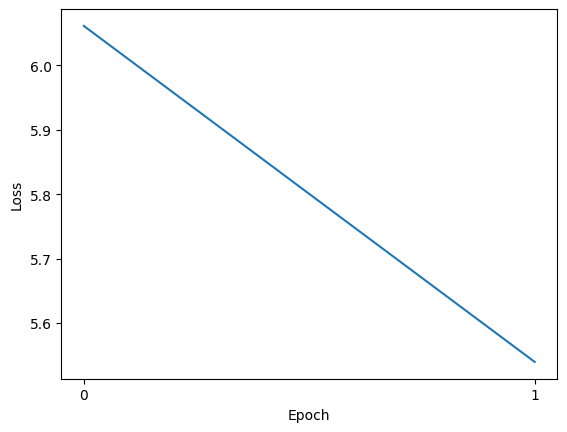

In [43]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(epoch_losses)))
plt.plot(epoch_losses)

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

## Attention---Testing

In [44]:
# student check - the following test must return a value less than 1000 to receive credit (20 pts)
ag.eval_attn(max_perplexity=1000)

Perplexity = 369.260498046875
Perplexity is less than 1000
Test J: 20/20


# Grading

Please submit this .ipynb file to Gradescope for grading.

## Final Grade

In [ ]:
# student check
ag.final_grade()

Your projected points for this assignment is 100/100.

NOTE: THIS IS NOT YOUR FINAL GRADE. YOUR FINAL GRADE FOR THIS ASSIGNMENT WILL BE AT LEAST 100 OR MORE, BUT NOT LESS



## Notebook Runtime

In [ ]:
# end time - notebook execution
end_nb = time.time()
# print notebook execution time in minutes
print("Notebook execution time in minutes =", (end_nb - start_nb)/60)
# warn student if notebook execution time is greater than 30 minutes
if (end_nb - start_nb)/60 > 30:
  print("WARNING: Notebook execution time is greater than 30 minutes. Your submission may not complete auto-grading on Gradescope. Please optimize your code to reduce the notebook execution time.")

Notebook execution time in minutes = 3.376316483815511
